Import Stuff

In [3]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

RW_NN Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device
        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator):
        unique, counts = torch.unique(graph_indicator, return_counts=True)
        n_graphs = unique.size(0)
        n_nodes = features.size(0)

        if self.normalize:
            norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
        
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        x = self.sigmoid(self.fc(features))
        z = self.features_hidden
        zx = torch.einsum("abc,dc->abd", (z, x))
        
        out = list()
        for i in range(self.max_step):
            if i == 0:
                eye = torch.eye(self.size_hidden_graphs, device=self.device)
                eye = eye.repeat(self.hidden_graphs, 1, 1)              
                o = torch.einsum("abc,acd->abd", (eye, z))
                t = torch.einsum("abc,dc->abd", (o, x))
            else:
                x = torch.spmm(adj, x)
                z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                t = torch.einsum("abc,dc->abd", (z, x))
            t = self.dropout(t)
            t = torch.mul(zx, t)
            t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
            t = torch.sum(t, dim=1)
            t = torch.transpose(t, 0, 1)
            if self.normalize:
                t /= norm
            out.append(t)
            
        out = torch.cat(out, dim=1)
        out = self.bn(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)
    def get_hidden_graphs_adjacency_list(self):
        """Converts the upper-triangular adjacency data to adjacency lists."""
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
        # Convert each hidden graph's adjacency matrix to an adjacency list
        adjacency_lists = []
        for i in range(self.hidden_graphs):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        
        return adjacency_lists

Hyperparameters for RWNN

In [5]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='synthetic',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=64,
    epochs=5,
    hidden_graphs=8,
    size_hidden_graphs=5,
    hidden_dim=4,
    penultimate_dim=32,
    max_step=2,
    normalize=False,
)

Generate random graphs for synthetic dataset

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import random

open("graph_A.txt", "w").close()

open("graph_indicator.txt", "w").close()
open("graph_labels.txt", "w").close()
graph_indicator = 1
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.gnm_random_graph(n, m)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    print(nx.generate_adjlist(G))
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            print(str(int(source) + 1))
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
    print(pairs)
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")

    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"0\n")
        graph_indicator += 1

<generator object generate_adjlist at 0x16d981120>
2
2
2
2
3
4
4
4
5
6
6
7
7
11
11
12
[('2', '8'), ('2', '3'), ('2', '11'), ('2', '6'), ('3', '6'), ('4', '8'), ('4', '6'), ('4', '14'), ('5', '9'), ('6', '12'), ('6', '16'), ('7', '14'), ('7', '16'), ('11', '12'), ('11', '14'), ('12', '16')]
<generator object generate_adjlist at 0x16d981200>
1
1
2
3
3
3
3
4
4
5
5
5
7
7
9
12
[('1', '14'), ('1', '3'), ('2', '10'), ('3', '8'), ('3', '16'), ('3', '13'), ('3', '7'), ('4', '14'), ('4', '10'), ('5', '7'), ('5', '15'), ('5', '8'), ('7', '12'), ('7', '16'), ('9', '10'), ('12', '16')]
<generator object generate_adjlist at 0x16d981200>
1
1
2
3
3
3
4
4
5
5
6
6
9
10
11
13
[('1', '4'), ('1', '13'), ('2', '11'), ('3', '8'), ('3', '14'), ('3', '11'), ('4', '16'), ('4', '5'), ('5', '12'), ('5', '6'), ('6', '8'), ('6', '16'), ('9', '10'), ('10', '13'), ('11', '13'), ('13', '15')]
<generator object generate_adjlist at 0x16d981200>
1
1
2
2
2
3
3
5
6
7
7
10
10
10
10
11
[('1', '4'), ('1', '7'), ('2', '4'), ('

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import random
   
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.cycle_graph(n)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
        
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")
    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"1\n")
        graph_indicator += 1

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Encoder

In [9]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=13)
it = 0
accs = list()

Train and test model

In [10]:
model = []

for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output = model(adj, features, graph_indicator)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))

        # Evaluate on validation set
        model.eval()
        val_loss = AverageMeter()
        val_acc = AverageMeter()

        for i in range(n_val_batches):
            output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
            val_loss.update(loss.item(), output.size(0))
            val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

        scheduler.step()
        
        # Print results
        print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
            "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
            "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))
        
        # Remember best accuracy and save checkpoint
        is_best = val_acc.avg >= best_acc
        best_acc = max(val_acc.avg, best_acc)
        if is_best:
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, 'model_best.pth.tar')

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()
    
print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))

/Users/danle/RWNN/hrwgnn/utils.py:44: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:653.)
  return torch.sparse.FloatTensor(indices, values, shape)


Cross-val iter: 01 epoch: 001 train_loss= 0.70133 train_acc= 0.45000 val_loss= 3.84506 val_acc= 0.60000 time= 0.15682
Cross-val iter: 01 epoch: 002 train_loss= 0.71054 train_acc= 0.47500 val_loss= 2.32004 val_acc= 0.60000 time= 0.00429
Cross-val iter: 01 epoch: 003 train_loss= 0.68036 train_acc= 0.55000 val_loss= 1.53447 val_acc= 0.60000 time= 0.00967
Cross-val iter: 01 epoch: 004 train_loss= 0.69567 train_acc= 0.47500 val_loss= 0.95435 val_acc= 0.60000 time= 0.00661
Cross-val iter: 01 epoch: 005 train_loss= 0.70425 train_acc= 0.40000 val_loss= 0.81438 val_acc= 0.60000 time= 0.00395
Optimization finished!
Loading checkpoint!
test_loss= 0.77618 test_acc= 0.60000

Cross-val iter: 02 epoch: 001 train_loss= 0.70227 train_acc= 0.55000 val_loss= 0.65478 val_acc= 0.80000 time= 0.00314
Cross-val iter: 02 epoch: 002 train_loss= 0.67037 train_acc= 0.57500 val_loss= 0.86168 val_acc= 0.80000 time= 0.00274
Cross-val iter: 02 epoch: 003 train_loss= 0.62113 train_acc= 0.62500 val_loss= 1.17773 val_ac

/var/folders/qp/2rm9qtrn4bx8cwcdd8dr1f980000gn/T/ipykernel_51215/258026875.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')

Cross-val iter: 07 epoch: 005 train_loss= 0.67672 train_acc= 0.57500 val_loss= 2.04456 val_acc= 0.80000 time= 0.00238
Optimization finished!
Loading checkpoint!
test_loss= 6.13360 test_acc= 0.40000

Cross-val iter: 08 epoch: 001 train_loss= 0.68581 train_acc= 0.47500 val_loss= 7.12700 val_acc= 0.20000 time= 0.00305
Cross-val iter: 08 epoch: 002 train_loss= 0.66088 train_acc= 0.70000 val_loss= 7.35444 val_acc= 0.20000 time= 0.00252
Cross-val iter: 08 epoch: 003 train_loss= 0.64857 train_acc= 0.55000 val_loss= 6.90035 val_acc= 0.20000 time= 0.00240
Cross-val iter: 08 epoch: 004 train_loss= 0.68661 train_acc= 0.52500 val_loss= 6.17013 val_acc= 0.20000 time= 0.00232
Cross-val iter: 08 epoch: 005 train_loss= 0.67331 train_acc= 0.45000 val_loss= 5.37168 val_acc= 0.20000 time= 0.00246
Optimization finished!
Loading checkpoint!
test_loss= 4.02906 test_acc= 0.40000

Cross-val iter: 09 epoch: 001 train_loss= 0.71229 train_acc= 0.42500 val_loss= 5.21573 val_acc= 0.40000 time= 0.00266
Cross-val it

Print adjacency lists of hidden graphs

In [11]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Print the adjacency lists for each hidden graph
for i, adj_list in enumerate(adjacency_lists):
    print(f"Hidden Graph {i}:")
    for node, neighbors in adj_list.items():
        print(f"  Node {node}: {neighbors}")

Hidden Graph 0:
  Node 0: [np.int64(1), np.int64(2)]
  Node 1: [np.int64(0), np.int64(3)]
  Node 2: [np.int64(0), np.int64(3)]
  Node 3: [np.int64(1), np.int64(2), np.int64(4)]
  Node 4: [np.int64(3)]
Hidden Graph 1:
  Node 0: [np.int64(1), np.int64(4)]
  Node 1: [np.int64(0), np.int64(2)]
  Node 2: [np.int64(1), np.int64(3)]
  Node 3: [np.int64(2)]
  Node 4: [np.int64(0)]
Hidden Graph 2:
  Node 0: [np.int64(2), np.int64(4)]
  Node 1: [np.int64(2), np.int64(4)]
  Node 2: [np.int64(0), np.int64(1)]
  Node 3: []
  Node 4: [np.int64(0), np.int64(1)]
Hidden Graph 3:
  Node 0: [np.int64(1), np.int64(4)]
  Node 1: [np.int64(0), np.int64(2), np.int64(3)]
  Node 2: [np.int64(1), np.int64(3)]
  Node 3: [np.int64(1), np.int64(2), np.int64(4)]
  Node 4: [np.int64(0), np.int64(3)]
Hidden Graph 4:
  Node 0: [np.int64(3)]
  Node 1: [np.int64(2), np.int64(3)]
  Node 2: [np.int64(1)]
  Node 3: [np.int64(0), np.int64(1)]
  Node 4: []
Hidden Graph 5:
  Node 0: [np.int64(1), np.int64(2), np.int64(4)]
  N

Display all hidden graphs

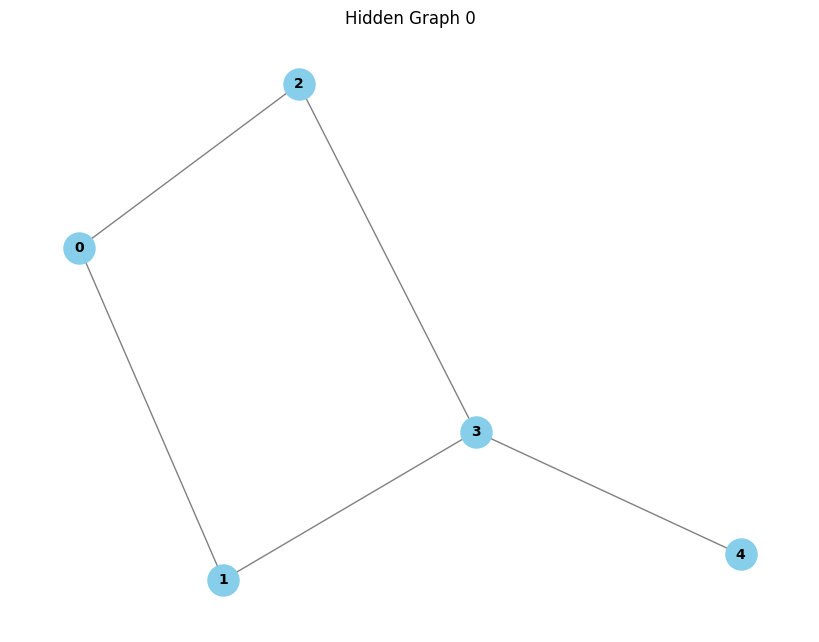

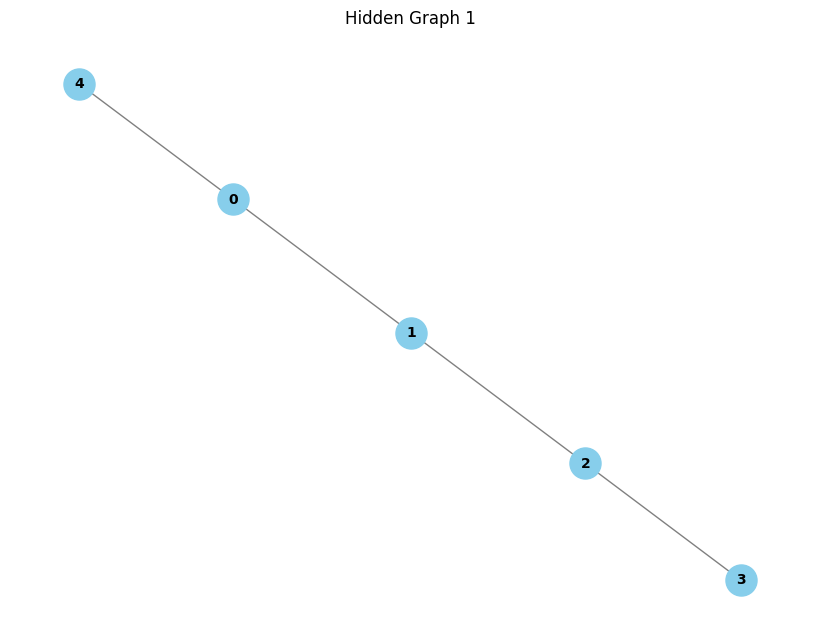

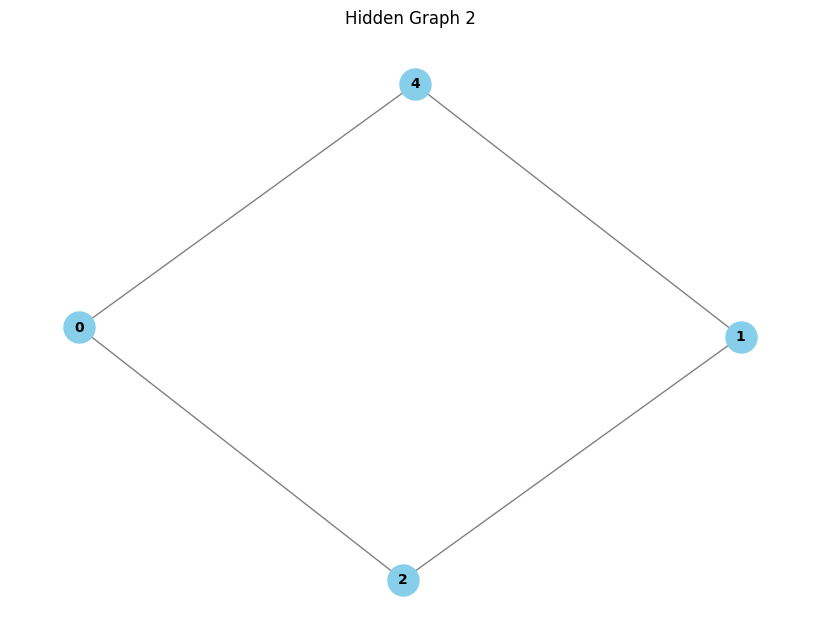

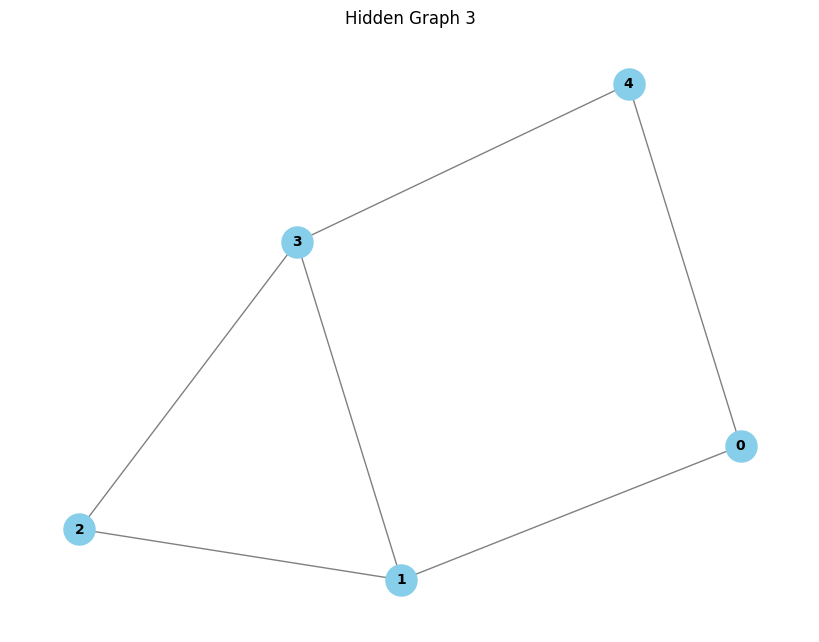

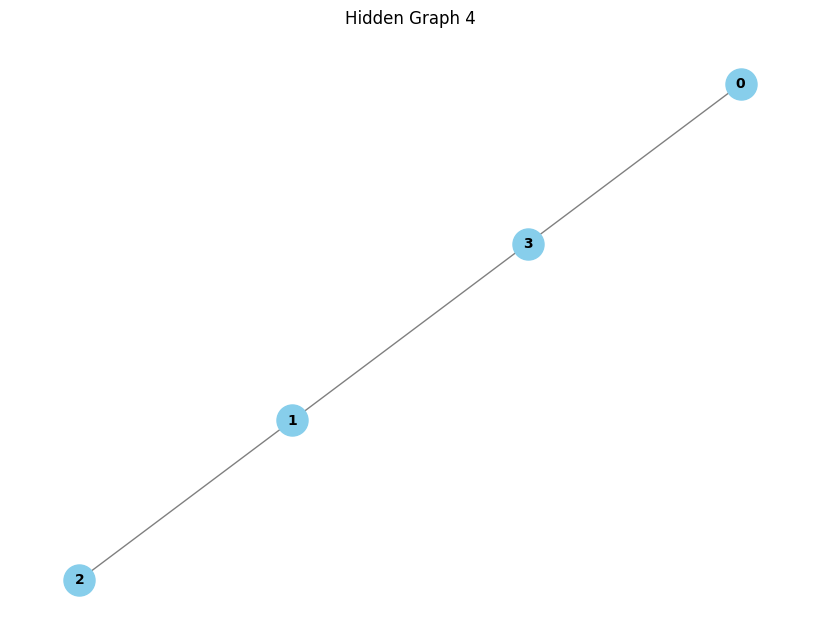

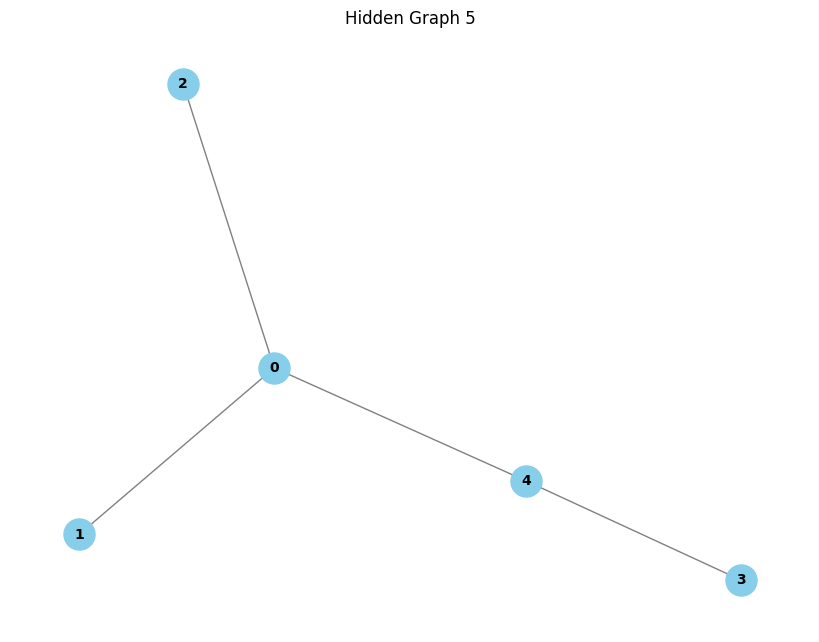

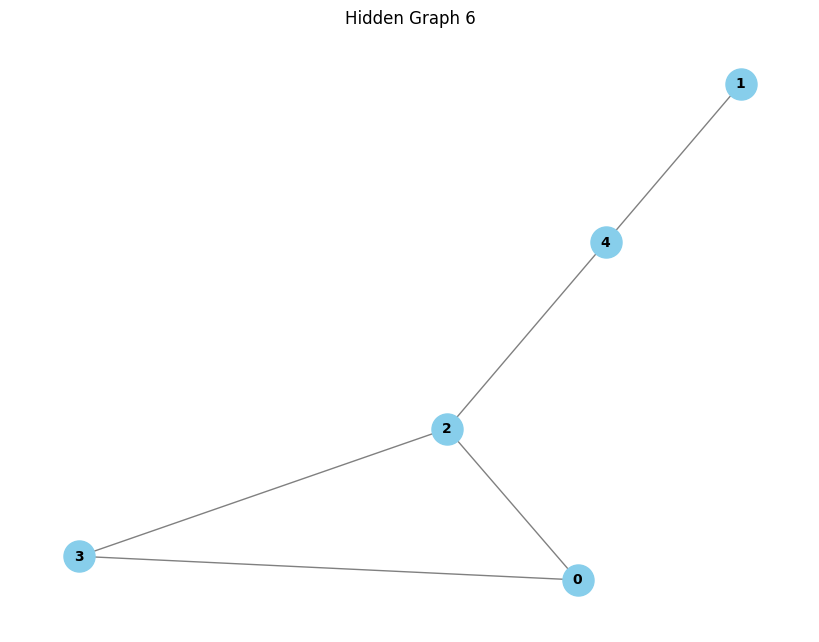

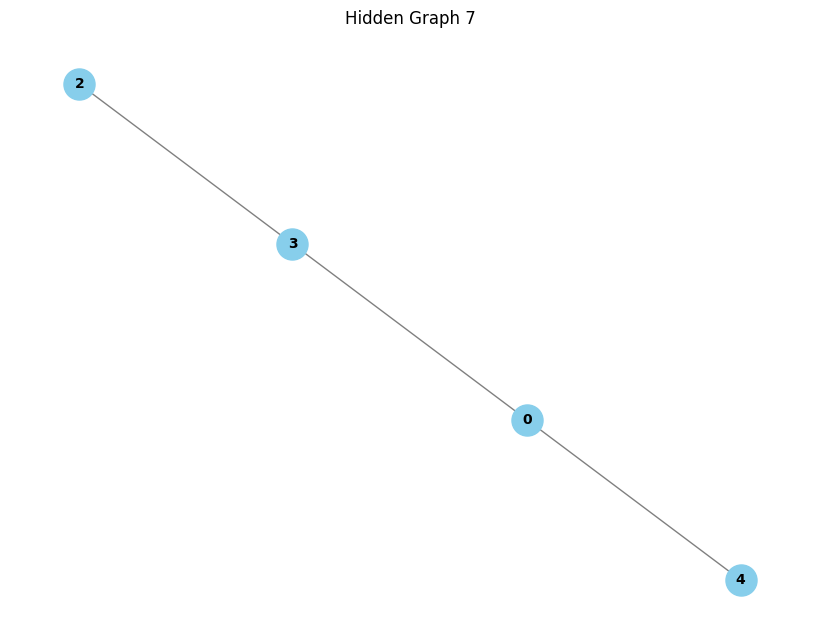

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming model is defined and adjacency lists are obtained as follows:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Positioning the nodes using the spring layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title(f"Hidden Graph {i}")
    plt.show()


Test if two hidden graphs are isomorphic

In [13]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

graphs = []

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    for j, graph in enumerate(graphs):
        if nx.is_isomorphic(graph, G):
            print("Graph", i, "is isomorphic to previous graph", j)

    graphs.append(G)
    

Graph 7 is isomorphic to previous graph 4


Edit distance between hidden graphs

In [14]:
graph_dist_adj_matrix = np.zeros(shape=(len(graphs),len(graphs)))

for i, graph_1 in enumerate(graphs):
    for j, graph_2 in enumerate(graphs):
        if i == j:
            continue

        graph_edit_distance = nx.graph_edit_distance(graph_1, graph_2)
        print('Edit distance between graph', i, ' and graph', j, ':', graph_edit_distance)
        graph_dist_adj_matrix[i, j] = graph_edit_distance
        
print(graph_dist_adj_matrix)

Edit distance between graph 0  and graph 1 : 1.0
Edit distance between graph 0  and graph 2 : 2.0
Edit distance between graph 0  and graph 3 : 1.0
Edit distance between graph 0  and graph 4 : 3.0
Edit distance between graph 0  and graph 5 : 1.0
Edit distance between graph 0  and graph 6 : 2.0
Edit distance between graph 0  and graph 7 : 3.0
Edit distance between graph 1  and graph 0 : 1.0
Edit distance between graph 1  and graph 2 : 3.0
Edit distance between graph 1  and graph 3 : 2.0
Edit distance between graph 1  and graph 4 : 2.0
Edit distance between graph 1  and graph 5 : 2.0
Edit distance between graph 1  and graph 6 : 1.0
Edit distance between graph 1  and graph 7 : 2.0
Edit distance between graph 2  and graph 0 : 2.0
Edit distance between graph 2  and graph 1 : 3.0
Edit distance between graph 2  and graph 3 : 3.0
Edit distance between graph 2  and graph 4 : 1.0
Edit distance between graph 2  and graph 5 : 3.0
Edit distance between graph 2  and graph 6 : 4.0
Edit distance betwee

Generate metagraph

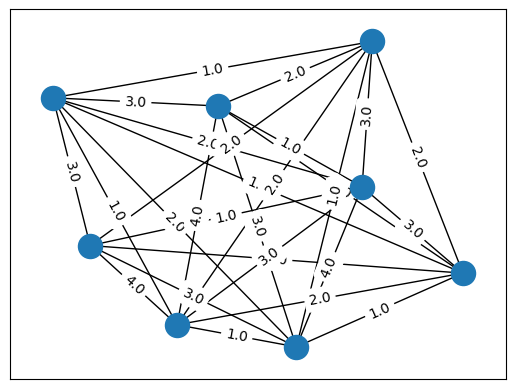

In [15]:
G = nx.from_numpy_array(graph_dist_adj_matrix)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

K-Means Clustering on metagraph

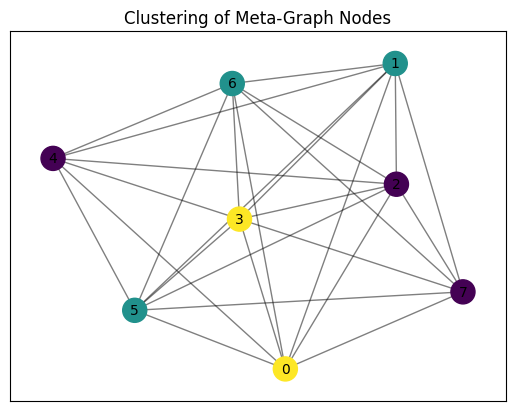

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# use metagraph adjacency matrix as node features
node_features = graph_dist_adj_matrix

# apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
reduced_features = pca.fit_transform(node_features)

# apply clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

# visualize metagraph with cluster labels
pos = nx.spring_layout(G)  # Spring layout for visualization
nx.draw_networkx_nodes(G, pos, node_color=cluster_labels, cmap='viridis', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Add labels (optional)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Clustering of Meta-Graph Nodes")
plt.show()
